<a href="https://colab.research.google.com/github/ManuSinghYadav/Walmart-Sales-Forecast/blob/main/Walmart_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the Data
It can be downloaded from [here](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast).

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [207]:
features = pd.read_csv('/content/Walmart-Sales-Forecast/features.csv')
stores = pd.read_csv('/content/Walmart-Sales-Forecast/stores.csv')
test = pd.read_csv('/content/Walmart-Sales-Forecast/test.csv')
train = pd.read_csv('/content/Walmart-Sales-Forecast/train.csv')

<ipython-input-207-ad108aaf380d>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/Walmart-Sales-Forecast/train.csv')


##Basic Exploration

In [57]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [58]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [59]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [60]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309679 entries, 0 to 309678
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         309679 non-null  int64  
 1   Dept          309679 non-null  int64  
 2   Date          309679 non-null  object 
 3   Weekly_Sales  309679 non-null  float64
 4   IsHoliday     309678 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ MB


In [62]:
train.describe()

,Store,Dept,Weekly_Sales
count,309679.000000,309679.000000,309679.000000
mean,16.219340,43.414981,17140.600746
std,9.071128,29.839534,23941.832113
min,1.000000,1.000000,-4988.940000
25%,8.000000,19.000000,2661.720000
50%,16.000000,36.000000,8337.490000
75%,24.000000,71.000000,21601.720000
max,32.000000,99.000000,693099.360000


In [63]:
max(train['Date'])

'2012-10-26'

In [117]:
min(test['Date'])

'2012-11-02'

In [143]:
print("Stores:", np.sort(train['Store'].unique()))

print("\nTotal Stores:", len(train['Store'].unique()))

Stores: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]

Total Stores: 32


In [141]:
print("Departments:", np.sort(train['Dept'].unique()))

print("\nTotal Departments:", len(train['Dept'].unique()))

Departments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91
 92 93 94 95 96 97 98 99]

Total Departments: 80


In [124]:
print("Total Unique Weeks:", len(train['Date'].unique()))

Total Unique Weeks: 143


In [166]:
train.groupby(['Store','Dept']).count()

Date  Weekly_Sales  IsHoliday
Store Dept                               
1     1      143           143        143
      2      143           143        143
      3      143           143        143
      4      143           143        143
      5      143           143        143
...          ...           ...        ...
32    38     143           143        143
      40     143           143        143
      41     143           143        143
      42     143           143        143
      44     138           138        137

[2404 rows x 3 columns]

In [168]:
# @title Analysis/ Result
# @markdown From the above analyis, it can be analyzed that we have **32 Stores** and *almost* each store is having **80 Departments**. And *almost* each department is having data for **143 weeks**.


##Data Preprocessing
Setting up the index

In [210]:
train.index = train['Date']

In [211]:
train = train.drop(['Date'], axis = 1)

In [212]:
train.index = pd.to_datetime(train.index)

In [213]:
train.index.dtype

dtype('<M8[ns]')

##Forecasting of S1D1
Lets start from short. Let's do forecasting for Store No. 1 and its Dept No. 1

Lets create a Data frame with only data consisting for store no. 1 and its dept no. 1

In [226]:
s1d1 = train[train['Store']==1]
s1d1 = s1d1[s1d1['Dept']==1]

s1d1

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-09-28,1,1,18947.81,False
2012-10-05,1,1,21904.47,False
2012-10-12,1,1,22764.01,False


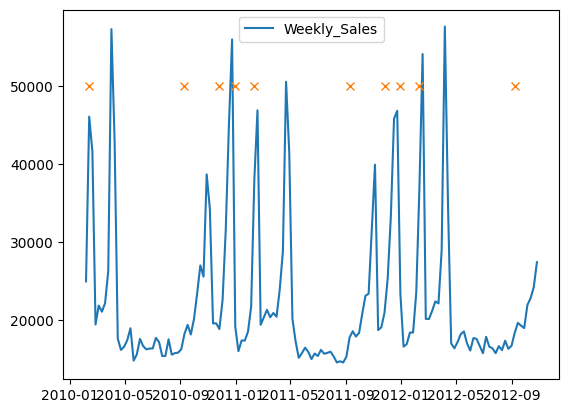

In [222]:
plt.plot(s1d1.index,b['Weekly_Sales'], label='Weekly_Sales')
plt.plot(s1d1[s1d1['IsHoliday']==True].index, np.ones(10)*50000, 'x')
plt.legend();

Here it can be seen that there is some correaltion with the holidays.

####ETS Decomposition

In [233]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(s1d1['Weekly_Sales'], model= 'additive')

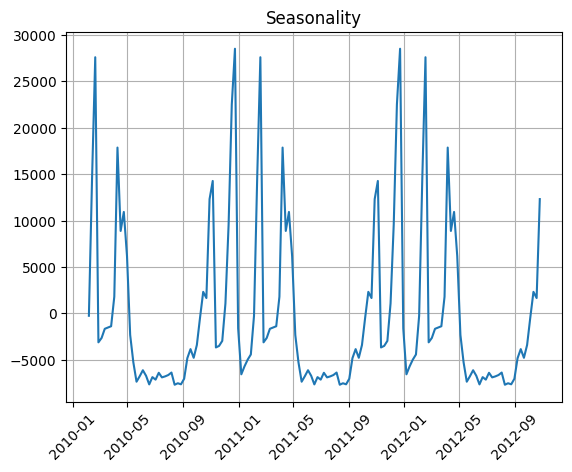

In [259]:
plt.title("Seasonality")
plt.plot(result.seasonal)
plt.xticks(rotation=45)
plt.grid();

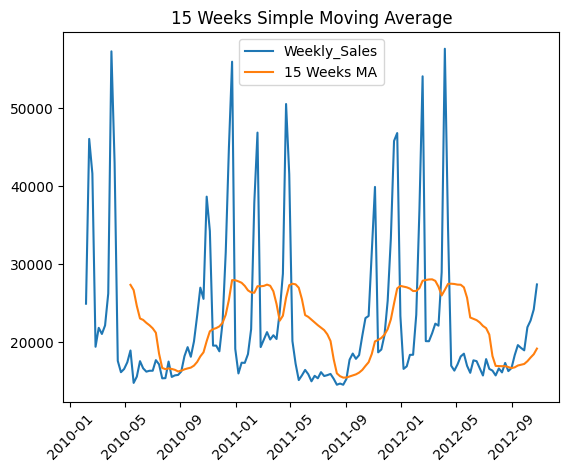

In [261]:
plt.title("15 Weeks Simple Moving Average")
plt.plot(s1d1['Weekly_Sales'], label='Weekly_Sales')
plt.plot(s1d1['Weekly_Sales'].rolling(window = 15).mean(), label = '15 Weeks MA')
plt.xticks(rotation=45)
plt.legend();

Based on the two charts above, it can be concluded that there is a clear seasonality. There appear to be seasonal valleys in between May and September, and the activity levels seem to peak in January and April.